# Going Deeper 8. GO/STOP! - Object Detection 시스템 만들기

## 1. 자율주행 보조장치 (1) KITTI 데이터셋

자율주행 보조장치 object detection 요구사항  
- 1. 사람이 카메라에 감지되면 정지  
- 2. 차량이 일정 크기 이상으로 감지되면 정지

![alt text](kitti.png "Title")

### 필요한 라이브러리 불러오기

In [8]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/content/drive/MyDrive/Going_Deeper'

print('슝=3')


슝=3


#### kitti 데이터셋 다운로드 -> 엄청 오래걸림... 한 30분?

In [9]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


In [10]:
## 주요 라이브러리 버전을 확인하기!

import tensorflow as tf

print(tf.__version__)

2.8.0


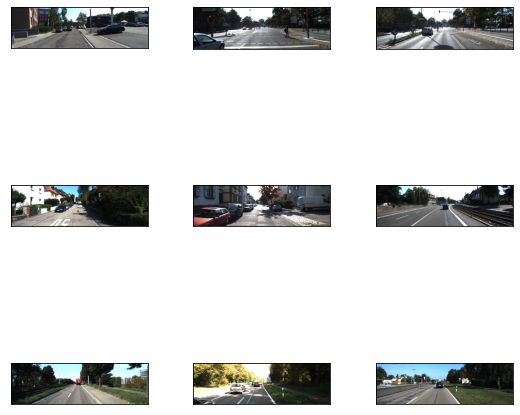

In [11]:
## KITTI 데이터셋을 tfds.show_examples 를 통해서 보기!

_ = tfds.show_examples(ds_train, ds_info)

다양한 각도로 찍힌 사진을 확인할 수 있다!

In [12]:
## 데이터셋의 정보 확인하기

ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

- 데이터
    -  6,347개의 학습 데이터(training data)  
    -  711개의 평가용 데이터(test data)  
    - 423개의 검증용 데이터(validation data)  
로 구성되어 있다.  






- 라벨
    - alpha
    - bbox
    - dimensions
    - location
    - occluded
    - rotation_y
    - truncated

## 2. 자율주행 보조장치 (2) 데이터 직접 확인하기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.86, 1.78, 1.66], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.15      , 0.2015781 , 0.47650668, 0.35160226],
       [0.30914667, 0.3097182 , 0.5501867 , 0.39968598],
       [0.43210667, 0.4125282 , 0.52104   , 0.44924316]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.39, 1.48, 3.76],
       [1.81, 1.66, 4.05],
       [1.46, 1.75, 4.23]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-3.74,  1.78, 10.66],
       [-3.8 ,  1.76, 16.65],
       [-3.51,  1.79, 34.16]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 1, 0])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.53, 1.56, 1.56], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0.,

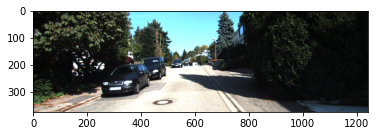

In [13]:
## 데이터셋을 직접 확인해보기!

sample = ds_train.take(1)      ## 이게 데이터셋을 하나씩 뽑아볼 수 있는 코드 !

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

위에 정보를 보고 밑에 사진처럼 바운딩 박스를 그려서 시각화 해보자!!!!

![alt text](1.png "Title")

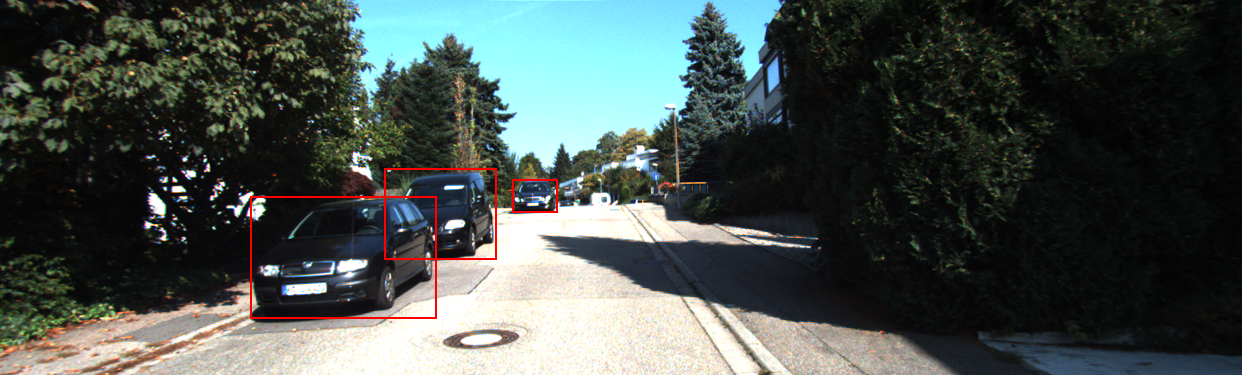

In [14]:
## 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.

def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    ## 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    ## 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 3. RetinaNet

- RetinaNet은 Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델이다.   

## 4. 데이터 준비

#### 데이터 파이프 라인     

먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸어 주어야 한다. 이때 사용할 데이터 파이프라인을 구축한다.

데이터 파이프라인은 총 4단계  

1. x와 y좌표 위치 교체  
2. 무작위로 수평 뒤집기(Flip)  
3. 이미지 크기 조정 및 패딩 추가  
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [15]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


In [16]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


이미지 크기를 바꿀 때는 고려할 점  


- 이미지의 비율은 그대로 유지  
- 이미지의 최대/최소 크기도 제한해야함
- 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들것이다

In [17]:
## 실제로 입력할 이미지를 어떻게 바꿀지에 대해서는
## min_side, max_side, min_side_range, stride등에 의해 결정 된다.

def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


In [18]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


In [19]:
## 위에 우리가 준비한 함수들을 연결해준다.

def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


#### 인코딩  

One stage detector에서는 Anchor Box라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정된다.   
그래서 기본적으로 Anchor Box를 생성해줘야 한다. Anchor Box로 생성되는 것은 물체 위치 후보라고 생각하면 됩니다.   
물체 위치를 주관식이 아닌 객관식으로 풀게 하는 것이다.

In [20]:
## Anchor Box를 생성

class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


In [21]:
## 입력할 데이터를 Anchor Box에 맞게 변형해줘야한다.

def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


이제 실제 라벨을 Anchor Box에 맞춰주는 클래스를 만들어 보자!!!!    위에서 작성한 compute_iou 함수를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해 준다.

In [22]:
## 이 과정은 데이터를 훈련이 가능한 형식으로 encode하는 것 같으니 
## LabelEncoder라는 이름으로 클래스를 만들었음

class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


## 5. 모델 작성  


앞서 설명했듯이 RetinaNet에서는 FPN(Feature Pyramid Network)를 사용한다.

In [23]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


- Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요하다. 그것을 head라고 부르기도 함  
-  각각의 head를 만들어 주는데!  head부분은 유사한 형태로 만들 수 있으니 build_head라는 함수를 하나만 만들고 두 번 호출하면 될 것 같음!

In [24]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


In [25]:
## 우리가 만들 RetinaNet의 backbone은 ResNet50 이다.
## FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해 준다.

def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


이제 RetinaNet을 완성해 보자!! . Backbone + FPN + classification용 head + box용 head 이다.

In [26]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


이제 모델을 준비했고, Loss에 대한 준비를 해보자!!!

In [27]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


## 6. 모델 학습


앞에 만들어 둔 클래스와 함수를 이용해서 모델을 조립하고 학습시켜보자!!

In [28]:
num_classes = 8
batch_size = 8       ## batch_size 가 원래 2로 설정되어있는데 너무 학습이 오래걸림..
## 근데 8 이상으로 키우면 터져서,,, 최대가 8으로!!!

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

슝=3


다음으로 Learning Rate  
논문에서는 8개의 GPU를 사용했기 때문에 우리 환경과는 맞지 않아서 Learning Rate를 적절히 바꿔줌.

In [29]:
##  Learning Rate
## Optimizer는 동일하게 SGD를 사용

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [30]:
## 데이터 전처리를 위한 파이프라인도 만들어 주기!!~!~!~!

label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

슝=3


#### 대망의 학습,,,,  
에폭을 20번 돌렸는데 엄청 오래걸렸다.. 그리고 심지어 20번을 했지만 런타임이 끊겨서 17번까지만 checkpoints가 저장되었다.....너무 속상하지만 loss를 보니까 아마 비슷했을 것 같다!!!

In [31]:
# model_dir = '/content/drive/MyDrive/Going_Deeper/model_save'
# callbacks_list = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
#         monitor="loss",
#         save_best_only=False,
#         save_weights_only=True,
#         verbose=1,
#     )
# ]

# epochs = 20

# model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     callbacks=callbacks_list
# )

![alt text](epoch.png "Title")

## 7. 결과 확인하기

In [32]:
## 학습된 모델을 불러오기

model_dir = '/content/drive/MyDrive/Going_Deeper/model_save'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print("슝")

슝


In [33]:
## 모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어준다!!
##  100개의 후보만 골라 처리

class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


In [34]:
## 추론이 가능한 모델을 조립하기

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


In [35]:
## 모델의 추론 결과를 시각화 할 함수를 만들어주자!!!!

def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        
        ## 대박 
        y1 = image.shape[0] - y2

        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


추론시에 입력 데이터를 전처리하기 위함 함수를 만들어주자!!!     

학습을 위한 전처리랑 추론을 위한 전처리는 다르기 때문에 따로 작성한 것이다.!!

In [36]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


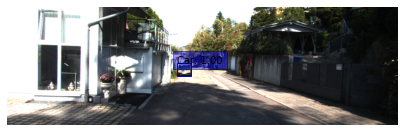

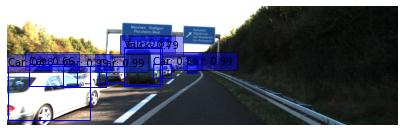

In [37]:
## 학습 된 결과를 확인해보기!!
## 바운딩 박스가 잘 만들어진 것을 볼 수 있음!!!

test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# 프로젝트: 자율주행 보조 시스템 만들기

## 1. 자율주행 시스템 만들기  



위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.  
- 입력으로 이미지 경로를 받습니다.  
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.  
- 조건은 다음과 같습니다.  
    - 사람이 한 명 이상 있는 경우  
    - 차량의 크기(width or height)가 300px이상인 경우

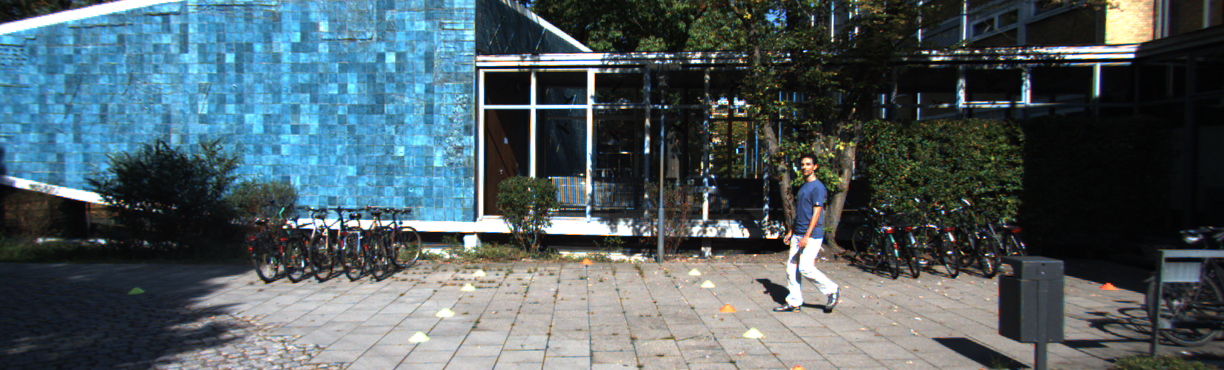

In [39]:
## 이미지 경로로 사진확인!

img_path = '/content/drive/MyDrive/Going_Deeper/images/stop_1.png'
image = Image.open(img_path).convert('RGB')
image

In [38]:
def get_object_detection_result(image):
    int2str = ds_info.features["objects"]["type"].int2str

    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]

    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    scores = detections.nmsed_scores[0][:num_detections]

    return image, boxes, class_names, scores

In [40]:
img_path = '/content/drive/MyDrive/Going_Deeper/images/stop_1.png'

def self_drive_assist(img_path, size_limit=300, visualize=True,
                     people_list = ['Pedestrian', 'Person_sitting', 'Cyclist']
):


    image = Image.open(img_path).convert('RGB')
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image, boxes, class_names, scores = get_object_detection_result(image)
    
    ## 시각화
    if visualize:
        visualize_detections(image, boxes, class_names, scores)

    ## 정지조건 1: 사람 한 명 이상 있는 경우 "Stop"
    if len(set(class_names) & set(people_list)) > 0:
        return "Stop"

    ## 정지조건 2: 차량 크기(W,H)가 300px 이상인 경우 "Stop"
    for box, class_name, score in zip(boxes, class_names, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        ## print(f"w {w:.2f}, h {h:.2f}, w*h {w*h:.2f}")  ## 자동차 크기 출력
        if w >= size_limit or h >= size_limit:
            return "Stop"
            
    ## 아니면 "Go"
    return "Go"
            

## 2. 자율주행 시스템 평가하기  
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [41]:
import os

def test_system(func):
    work_dir = '/content/drive/MyDrive/Going_Deeper/images'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        img_path= work_dir + '/' + image_file
        pred = func(img_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")


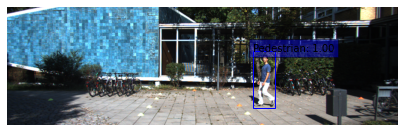

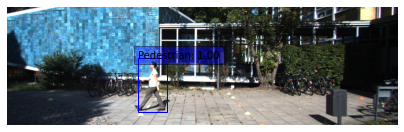

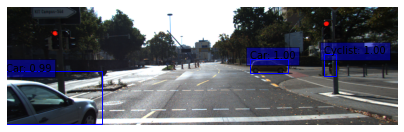

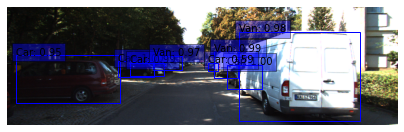

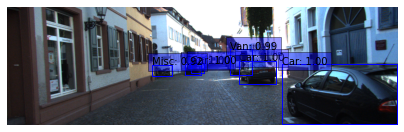

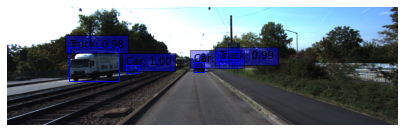

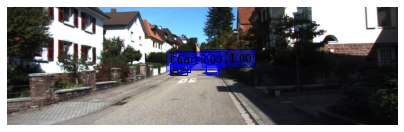

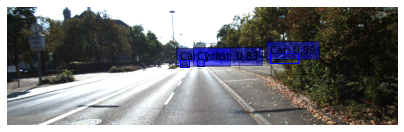

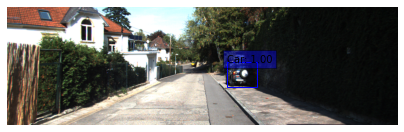

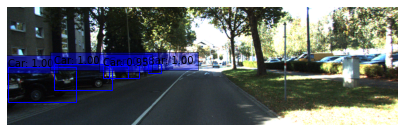

90점입니다.


In [42]:
test_system(self_drive_assist)

In [2]:
## pillow 버전확인!!  

import PIL
PIL.PILLOW_VERSION

/tmp/ipykernel_48/1632588596.py:2: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  PIL.PILLOW_VERSION


'8.3.2'

In [ ]:
## pillow 버전을 업그레이드 하기!!

!pip install --upgrade pillow

In [ ]:
## pillow 버전확인!! 

print(PIL.__version__)

# 회고!

## <어려웠던 점>  
이번 노드는 진~짜 개념도 어려웠고 코드 구현은 그냥 정신이 헤롱헤롱 했던 것 같다. 이번 노드를 하면서 RetinaNet 에 대해서 알게 되었는데 정말 처음 봤을 때는 무슨말인지 한 개도 몰랐고 그냥 글은 글이고 그림은 그림이었다,,,,ㅠㅠ 그리고 배치사이즈가 작다 보니까 에폭 하나 당 30분에서 40분이나 걸렸는데 와중에 중간에 끊겨서 속상했다.. 프로젝트 코드도 직접 조건에 맞춰서 구현을 하는 것이라서 매우 쉽지 않았고 어려웠던 노드였다. 

## <알게된 점 & 아직 모호한 점>  
이번에는 내용도 많고 이것저것 함수도 구현이 많이 되어서 뭐가 무슨 코드인지 어려웠는데 그만큼 시간을 많이 투자했던 것 같고 마크다운이랑 주석을 일일히 달았다. 그래서 그런지 보기가 조금 더 쉬워졌고 뭔가 알게된 점이라는게 딱 없는데 (RetinaNet 을 아직 마스터 못함...) 그냥 전체적인 코드를 처음 봤을 때보다 아 뭐가 뭐를 구현하는 코드라는 것을 알게되었던 것 같다!!!!

## <시도한 점>  
주피터에서는 코드를 짜고 코랩에서는 에폭을 돌렸다. 근데 주피터에서 잘 실행되었던 프로젝트 코드가 코랩에서는 돌아가지 않았다. 자꾸 에러가 떴는데 경로 문제도 아니었다.. 그래서 퍼실님과 함께 고민하면서 에러코드를 봤다. 그러니까 pillow version 이 주피터는 '8.3.2' 였는데 코랩은 '7.x.x' 였다. 버전이 더 낮아서 되지 않았던 것이었다. 그래서 pillow 버전을 업그레이드 하는 코드를 사용해서 업그레이드를 했다. 하고 나서 런타임을 초기화 하고 코드를 돌리니까 에러 없이 잘 돌아갔다. pillow 버전은 생각도 못했는데 생각보다 코드가 같다고 단순히 잘 되는 것이 아닌것을 알게 되었고,, 에러코드를 잘 봐야겠다고 생각했다.

## <자기다짐>  
이번에는 노드를 따라서 공부를 미리하고 프로젝트를 준비해서 그런지 프로젝트를 여유롭게 준비했던 것 같다. 그래서 여기에는 없지만 practice 코드를 보면 이것저것 여러가지 시도를 했다. 그래서 어려웠지만 나름 재밌었던 것 같다. 그리고 이번에 처음으로 코랩을 사용해서 코드를 짰는데 낯설었지만 경로를 잡는 것과 GPU 설정하는 것, 버전을 맞추는 것 여러가지를 알게 되었다. 그래서 배운 것도 많고 어려워서 힘들었던 노드였다. 뭔가 애착의 노드,,,,휴우 어렵고 힘들지만 곧 고딩디퍼도 끝이 보인다!!! 절반이나 했다!! 남은 것도 화이팅!!!!!!!!!